<a href="https://colab.research.google.com/github/ParkWonjeong/Limitless/blob/main/Limitless_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비트코인 시장 관련 데이터 분석

# Part 1. 시간적 특성 분석
### 비트코인은 언제 움직이는가?

비트코인 시장은 365일 24시간 열려있지만, 전 세계 투자자들의 활동 시간은 정해져있을 것이라고 생각됩니다. 요일과 시간대별로 수익률과 변동성이 어떻게 다른지 분석하여, 트레이딩 봇이 가장 유리한 시간대에 매매하고 위험한 시간대를 피할 수 있도록 돕는 근거를 마련하고자 합니다.




*   가설 1: 미국 증시 개장 시간에 변동성이 가장 클 것이다.
*   가설 2: 주말과 같은 특정 요일에는 거래량이 줄어들며, 수익률 패턴에서 평일과 차이가 발생할 것이다.



#### 수익률 히트맵

/tmp/ipython-input-2209575933.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
[*********************100%***********************]  1 of 1 completed


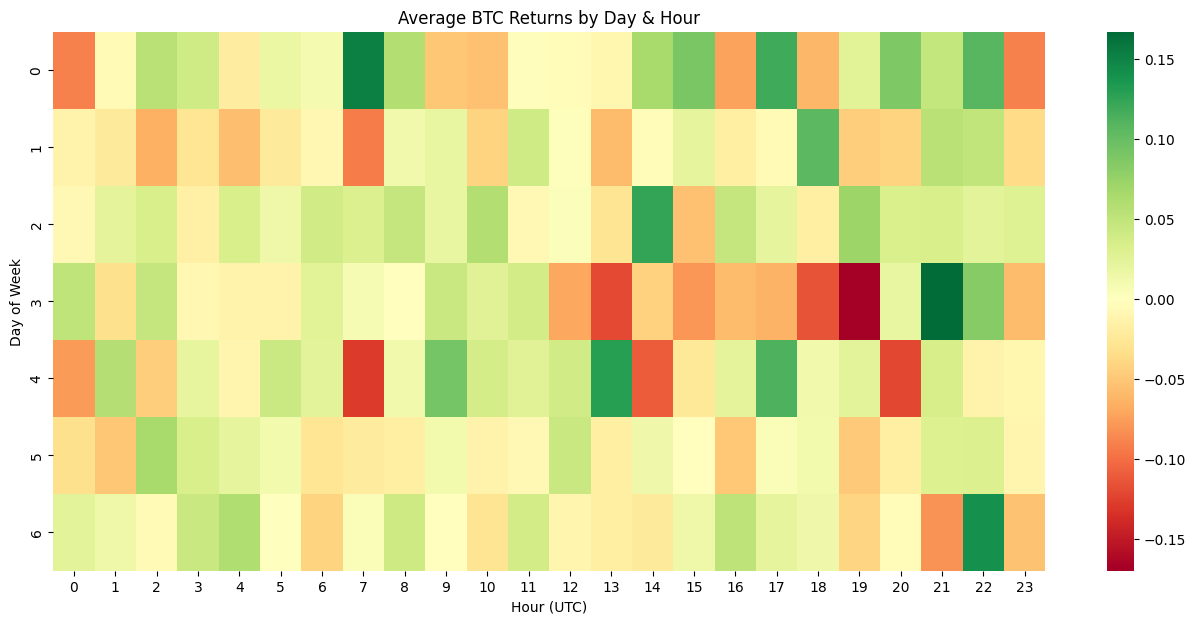

In [2]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기 (최근 2년치 1시간 봉)
df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
# 다중 인덱스 처리
if isinstance(df_raw.columns, pd.MultiIndex):
  df_raw.columns = df_raw.columns.get_level_values(0)

# 분석용 데이터프레임 만들기
df_ana = df_raw.copy()
df_ana['hour'] = df_ana.index.hour
df_ana['day_of_week'] = df_ana.index.dayofweek
df_ana['returns'] = df_ana['Close'].pct_change() * 100

# 요일별/시간별 평균 수익률 히트맵 계산
pivot_table = df_ana.pivot_table(values = 'returns',
                                 index = 'day_of_week',
                                 columns = 'hour',
                                 aggfunc = 'mean')


# 히트맵 시각화
plt.figure(figsize = (16, 7))
sns.heatmap(pivot_table, cmap = 'RdYlGn', center = 0)
plt.title('Average BTC Returns by Day & Hour')
plt.xlabel('Hour (UTC)')
plt.ylabel('Day of Week')
plt.show()



*   초록색: 해당 요일, 해당 시간에 평균적으로 가격이 많이 올랐음 (수익 구간)
*   빨간색: 해당 요일, 해당 시간에 평균적으로 가격이 많이 내렸음 (손실 구간)
*   노란색/흰색: 가격 변화가 거의 없는 구간





1.   변동성 집중: UTC 13시~22시 사이에 색깔이 가장 진하게 변함.
2.   요일별 특징: 목요일 오후는 전반적으로 색이 강함. 그에 반해 토요일이나 밤을 제외한 일요일과 같은 주말은 옅은 것으로 보아, 주말과 평일의 차이가 존재한다고 생각해볼 수 있음
3.   결론: 위 결과를 토대로 봤을 때, 목요일 오후에는 매매를 지양하는 것을 고려해볼 필요가 있음

#### 변동성 히트맵

/tmp/ipython-input-420250507.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
[*********************100%***********************]  1 of 1 completed


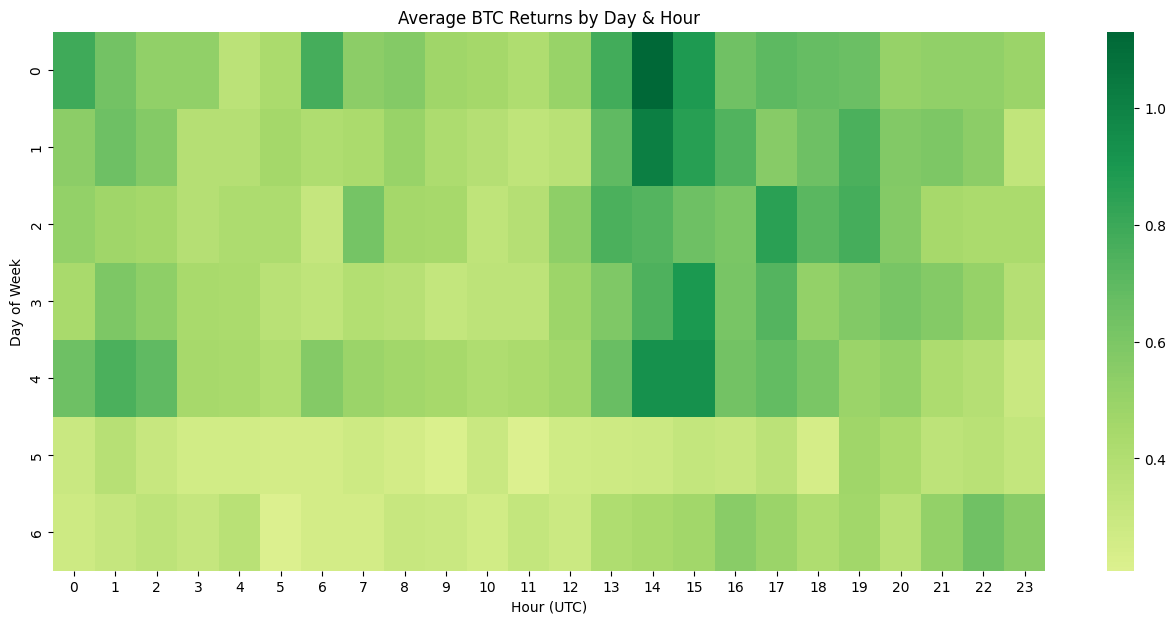

In [3]:
# 데이터 불러오기 (최근 2년치 1시간 봉)
df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
# 다중 인덱스 처리
if isinstance(df_raw.columns, pd.MultiIndex):
  df_raw.columns = df_raw.columns.get_level_values(0)

# 분석용 데이터프레임 만들기
df_ana = df_raw.copy()
df_ana['hour'] = df_ana.index.hour
df_ana['day_of_week'] = df_ana.index.dayofweek
df_ana['returns'] = df_ana['Close'].pct_change() * 100

# 요일별/시간별 평균 수익률 히트맵 계산
pivot_table = df_ana.pivot_table(values = 'returns',
                                 index = 'day_of_week',
                                 columns = 'hour',
                                 aggfunc = 'std')


# 히트맵 시각화
plt.figure(figsize = (16, 7))
sns.heatmap(pivot_table, cmap = 'RdYlGn', center = 0)
plt.title('Average BTC Returns by Day & Hour')
plt.xlabel('Hour (UTC)')
plt.ylabel('Day of Week')
plt.show()

변동성의 경우, 평일 오후, 특히 월요일과 금요일 14:00~16:00 사이의 변동성이 상당히 높은 것을 확인할 수 있음   
나아가 주말에는 평일보다 전반적인 색이 연하므로, 수익률 히트맵과 마찬가지로 평일과 주말의 차이를 보여주고 있음

# Part 2. 기술적 지표의 유효성 검증

다양한 기술적 지표가 있는데, 어떤 기술적 지표가 실질적인 매수 신호로서 가치가 있는지 검증하고, 비슷한 지표를 분류하여 불필요한 요소를 최대한 제거하기 위한 목적으로 분석합니다.